In [25]:
# 🧠 Brain Tumor MRI Classification – Preprocessing & Data Analysis

## Pre processing Steps
### 1. read images and create labels
# 2. normalize pixel values
# 3. better contraste
# 4. flatten images
# 5. save arrays
# 6. generate graphs
# 7. statistics

# The goal is to prepare clean, normalized data for supervised learning models  
# **(Linear Regression, Logistic Regression, SVM, and Neural Networks)**.

# Dataset source: **[Kaggle - Brain Tumor MRI Dataset]**(https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [26]:
!pip install opencv-python

import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

print(f"OpenCV version: {cv2.__version__}")

OpenCV version: 4.12.0


In [27]:
IMG_SIZE=128
def load_images(base_path):
    data, labels = [], []
    for label_name in ['tumor', 'notumor']:
        folder = os.path.join(base_path, label_name)
        label = 1 if label_name == 'tumor' else 0
        for filename in os.listdir(folder):
            if filename.endswith('.jpg'):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                img = cv2.equalizeHist((img * 255).astype('uint8')) / 255.0  
                data.append(img)
                labels.append(label)
    
    data, labels = shuffle(np.array(data), np.array(labels), random_state=42)
    return data, labels

In [28]:
dataset="../dataset"
X_train, y_train = load_images(os.path.join(dataset, "Training"))
X_test, y_test = load_images(os.path.join(dataset, "Testing"))

#Flatten data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [29]:
# Test loadimages images shapes
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

# see flatten images shapes
print("Train shape:", X_train_flat.shape)
print("Test shape:", X_test_flat.shape)

#save values as numpy array to later be processed through the models
np.savez_compressed("brain_mri_preprocessed.npz", 
                    X_train=X_train_flat, 
                    y_train=y_train,
                    X_test=X_test_flat,
                    y_test=y_test)

#see transformed data
unique, counts = np.unique(y_train, return_counts=True)
print(f"""
Test Info
-------------
Data type: {X_train.dtype}
Value range: {X_train.min():.3f} -> {X_train.max():.3f}
Class distribution: {dict(zip(unique, counts))}
""")

Train set: (5521, 128, 128) (5521,)
Test set: (1205, 128, 128) (1205,)
Train shape: (5521, 16384)
Test shape: (1205, 16384)

Test Info
-------------
Data type: float64
Value range: 0.000 -> 1.000
Class distribution: {np.int64(0): np.int64(1422), np.int64(1): np.int64(4099)}



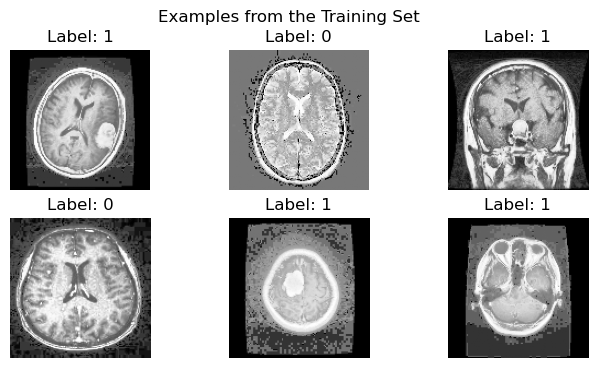

In [30]:
plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Examples from the Training Set")
plt.show()

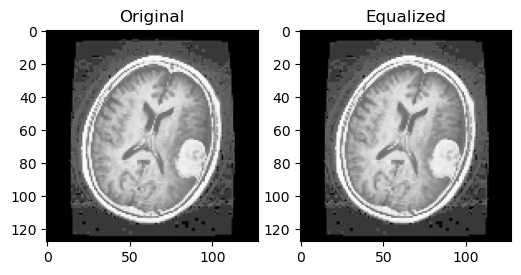

In [31]:
import cv2

original = (X_train[0] * 255).astype('uint8')
equalized = cv2.equalizeHist(original)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(original, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(equalized, cmap='gray')
plt.title("Equalized")
plt.show()

In [32]:
print("Training mean:", X_train.mean(), "Training std deviation:", X_train.std())
print("Testing mean:", X_test.mean(), "Testing std deviation:", X_test.std())

Training mean: 0.4448897689353889 Training std deviation: 0.3115030147829249
Testing mean: 0.44049170668737564 Testing std deviation: 0.31304270191110717


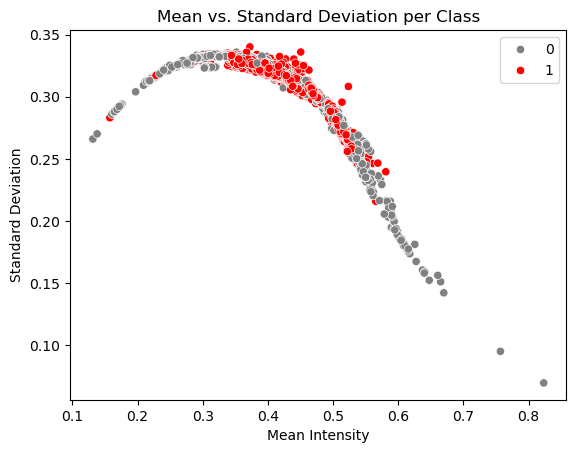

In [33]:
means = X_train.mean(axis=(1,2))
stds = X_train.std(axis=(1,2))
sns.scatterplot(x=means, y=stds, hue=y_train, palette=['gray','red'])
plt.title("Mean vs. Standard Deviation per Class")
plt.xlabel("Mean Intensity")
plt.ylabel("Standard Deviation")
plt.show()

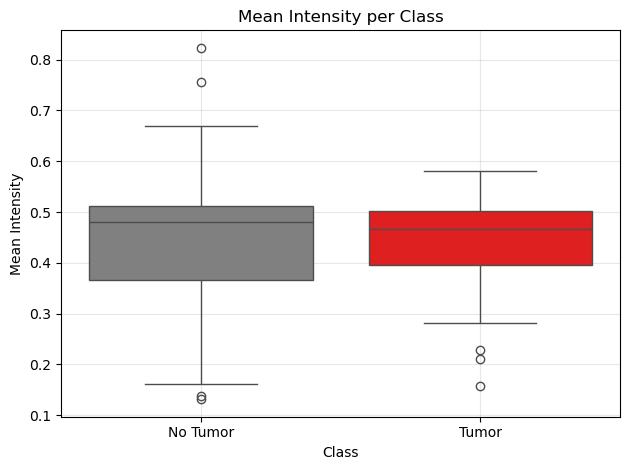

In [34]:
# Compute mean intensity for each image in train set
means_train = X_train_flat.mean(axis=1)

# Create DataFrame
df = pd.DataFrame({
    "mean_intensity": means_train,
    "label": y_train
})

# Map label to readable names
df["label_name"] = df["label"].map({0: "No Tumor", 1: "Tumor"})

sns.boxplot(data=df, x="label", y="mean_intensity", hue="label", palette=['gray', 'red'], legend=False)
plt.xticks([0,1], ["No Tumor", "Tumor"])
plt.title("Mean Intensity per Class", fontsize=12)
plt.xlabel("Class")
plt.ylabel("Mean Intensity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

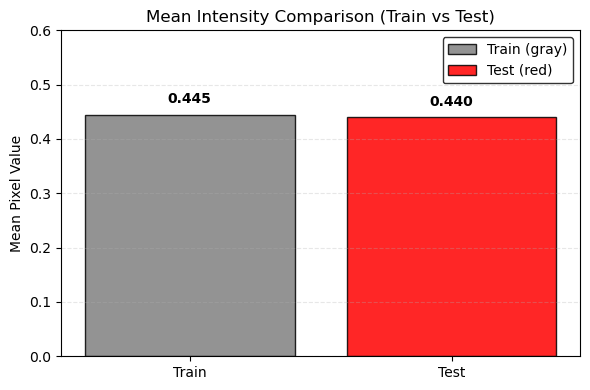

In [35]:
means_train = X_train_flat.mean()
means_test  = X_test_flat.mean()


plt.figure(figsize=(6,4))

# Cria as barras e define labels diretos
plt.bar('Train', means_train, color='gray', alpha=0.85, edgecolor='black', label='Train (gray)')
plt.bar('Test', means_test, color='red', alpha=0.85, edgecolor='black', label='Test (red)')

# Título e eixos
plt.title("Mean Intensity Comparison (Train vs Test)")
plt.ylabel("Mean Pixel Value")
plt.ylim(0, 0.6)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adiciona valores acima das barras
for i, v in enumerate([means_train, means_test]):
    plt.text(i, v + 0.015, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Legenda (agora funciona corretamente)
plt.legend(loc='upper right', frameon=True, facecolor='white', edgecolor='black')

plt.tight_layout()
plt.show()

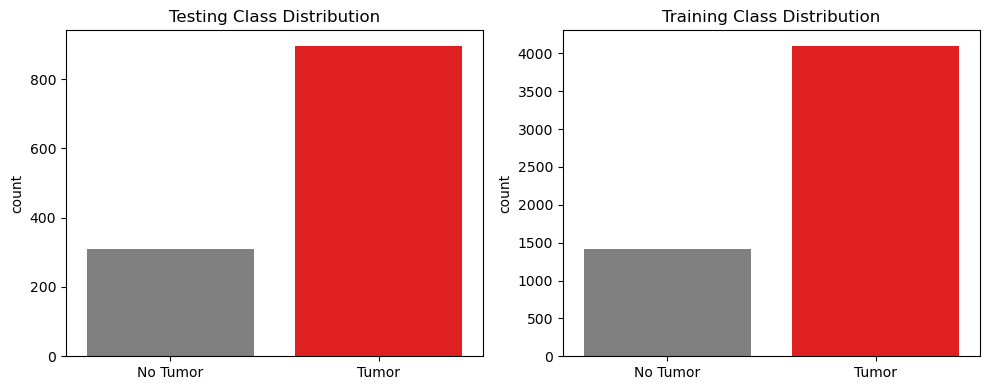

In [36]:
#Subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Test set ---
sns.countplot(ax=axes[0], x=y_test, palette=['gray', 'red'], hue=y_test, legend=False)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Tumor', 'Tumor'])
axes[0].set_title("Testing Class Distribution")

# --- Train set ---
sns.countplot(ax=axes[1], x=y_train, palette=['gray', 'red'], hue=y_train, legend=False)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Tumor', 'Tumor'])
axes[1].set_title("Training Class Distribution")

# Adjust layout
plt.tight_layout()
plt.show()

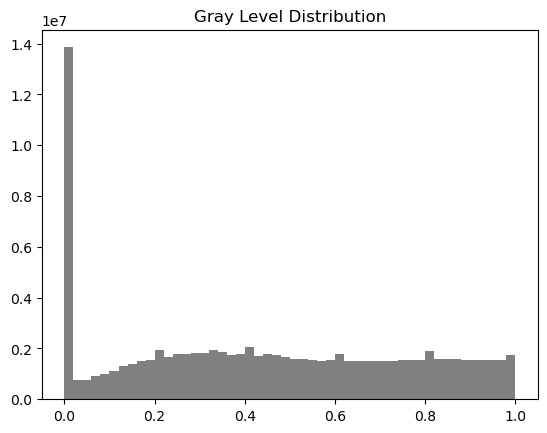

In [37]:
plt.hist(X_train.ravel(), bins=50, color='gray')
plt.title("Gray Level Distribution")
plt.show()

In [38]:
print(f"""
Dataset Summary
----------------
Training samples: {X_train.shape[0]}
Testing samples:  {X_test.shape[0]}
Total samples:    {X_train.shape[0] + X_test.shape[0]}
Image size:       {IMG_SIZE}x{IMG_SIZE}
Classes:          Tumor (1), No Tumor (0)
Mean intensity:   {X_train.mean():.3f}
Std deviation:    {X_train.std():.3f}
""")


Dataset Summary
----------------
Training samples: 5521
Testing samples:  1205
Total samples:    6726
Image size:       128x128
Classes:          Tumor (1), No Tumor (0)
Mean intensity:   0.445
Std deviation:    0.312



In [39]:
##To test the models use
##data = np.load("brain_mri_preprocessed.npz")
##X_train, y_train = data["X_train"], data["y_train"]
##X_test, y_test = data["X_test"], data["y_test"]